# **DepthPro: Human Segmentation**

This work is a part of the [**DepthPro: Beyond Depth Estimation**](https://github.com/geetu040/depthpro-beyond-depth) repository, which further explores the model's capabilities in:

- **Image Segmentation**: Human Segmentation  
- **Image Super Resolution**:  
  - 384px to 1536px (4x Upscaling)  
  - 256px to 1024px (4x Upscaling)

---

## 🛠️ Training

- The model has been trained on **Nvidia A40 (48GB GDDR6 VRAM)**.  
- To train this model, ensure at least **48GB GPU memory** is available for **float16 training**.

---

## 🤗 Inference

- For Web UI Inference: [**spaces/geetu040/DepthPro_Segmentation_Human**](https://huggingface.co/spaces/geetu040/DepthPro_Segmentation_Human)
- For Code-Based Inference and model weights: [**geetu040/DepthPro_Segmentation_Human**](https://huggingface.co/geetu040/DepthPro_Segmentation_Human)

---

## 🌐 Learn More About DepthPro

Check out the following resources for more details:

- **Official Paper**: [Depth Pro: Sharp Monocular Metric Depth in Less Than a Second](https://arxiv.org/abs/2410.02073)  
- **GitHub Repository**: [apple/ml-depth-pro](https://github.com/apple/ml-depth-pro)  
- **Articles**:  
  - [Apple unveils Depth Pro, an AI app that can map the depth of a 2D image](https://techxplore.com/news/2024-10-apple-unveils-depth-pro-ai.html)  
  - [Apple releases Depth Pro, an AI model that rewrites the rules of 3D vision](https://venturebeat.com/ai/apple-releases-depth-pro-an-ai-model-that-rewrites-the-rules-of-3d-vision/)

---

## 📊 For a Better Notebook Experience

- Open the notebook on **Google Colab**:  
  [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1IXKoCHqzOwszmRrUiynbbGL_SiCwWKPK)

---

# Notebook Overview

This notebook modifies [Apple's DepthPro for Monocular Depth Estimation](https://arxiv.org/abs/2410.02073) model for `Image Segmentation Task`.
1. The pre-trained depth estimation model is used with slight changes in the head layer to make it compatible with the segmentation task.
2. Hidden features maps have been generated to get the insights of the encoder and fusion stages of the model.
3. The model is then fine-tuned on the [Human Segmentation dataset](https://www.kaggle.com/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset) and final results have been visualized at the end of the notebook.

# Imports and Initial Setup

<details>

<summary>Installing Packages</summary>

```py
!pip install -q numpy pandas matplotlib pillow kagglehub lightning torch torchmetrics torchvision
!pip install -q git+https://github.com/geetu040/transformers.git@depth-pro-projects#egg=transformers
```

</details>

In [2]:
import os
import random
import math
import time
import kagglehub
from tqdm import tqdm
import warnings
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# custom installation from this PR: https://github.com/huggingface/transformers/pull/34583
# !pip install git+https://github.com/geetu040/transformers.git@depth-pro-projects#egg=transformers
from transformers import DepthProConfig, DepthProImageProcessorFast, DepthProForDepthEstimation

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
SPLIT_SIZE = 0.2

print("Device:", DEVICE)
print("Batch Size:", BATCH_SIZE)
print("Validation Split Size:", SPLIT_SIZE)

Device: cuda
Batch Size: 4
Validation Split Size: 0.2


In [4]:
# suppress all warnings
warnings.filterwarnings("ignore")

# hide output for unexpected keys when loading HF model
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

# precision trade-off for faster computation
# see: https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
torch.set_float32_matmul_precision("medium")

# Data Preparation

For `training` and `validation`, we use `Human Segmentation Dataset - Supervise.ly`, from kaggle: [tapakah68/supervisely-filtered-segmentation-person-dataset](https://www.kaggle.com/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset)
- It contains 2667 samples which are randomly split into 80% training and 20% validation.
- each sample contains an image and its corresponding mask.

create pytorch dataset class

In [5]:
class PersonSegmentationDataset(Dataset):
    """
    Pytorch Dataset for PersonSegmentation dataset.
    """
    kaggle_hub_path = "tapakah68/supervisely-filtered-segmentation-person-dataset"
    image_size = 1536  # pretrained depth-pro model uses this size

    def __init__(self):
        self.images_paths, self.masks_paths = self.download()
        assert len(self.images_paths) == len(self.masks_paths)

    def download(self):
        """
        Download the dataset from Kaggle Hub and return the paths of the images.
        """
        path = kagglehub.dataset_download(self.kaggle_hub_path)
        path = os.path.join(
            path, "supervisely_person_clean_2667_img/supervisely_person_clean_2667_img"
        )
        images_paths = os.path.join(path, "images")
        masks_paths = os.path.join(path, "masks")
        images_paths = [os.path.join(images_paths, i) for i in os.listdir(images_paths)]
        masks_paths  = [os.path.join(masks_paths, i) for i in os.listdir(masks_paths)]
        return images_paths, masks_paths

    def __len__(self):
        """
        Number of Images in the dataset.
        """
        return len(self.images_paths)

    def __getitem__(self, idx):
        """
        Load and return the input image and its binary mask.
        """
        image_path = self.images_paths[idx]
        mask_path  = self.masks_paths[idx]

        image = Image.open(image_path)
        image = image.convert("RGB")
        mask  = Image.open(mask_path)
        mask  = mask.convert("L")
        # some masks have values other than 255. for masks
        np_mask  = np.array(mask)
        np_mask[np_mask > 0] = 255
        mask  = Image.fromarray(np_mask)

        return image, mask

sample_image, sample_mask = PersonSegmentationDataset()[52]

100%|██████████| 4.31G/4.31G [00:54<00:00, 84.3MB/s]

Extracting files...


visualize a sample from the dataset

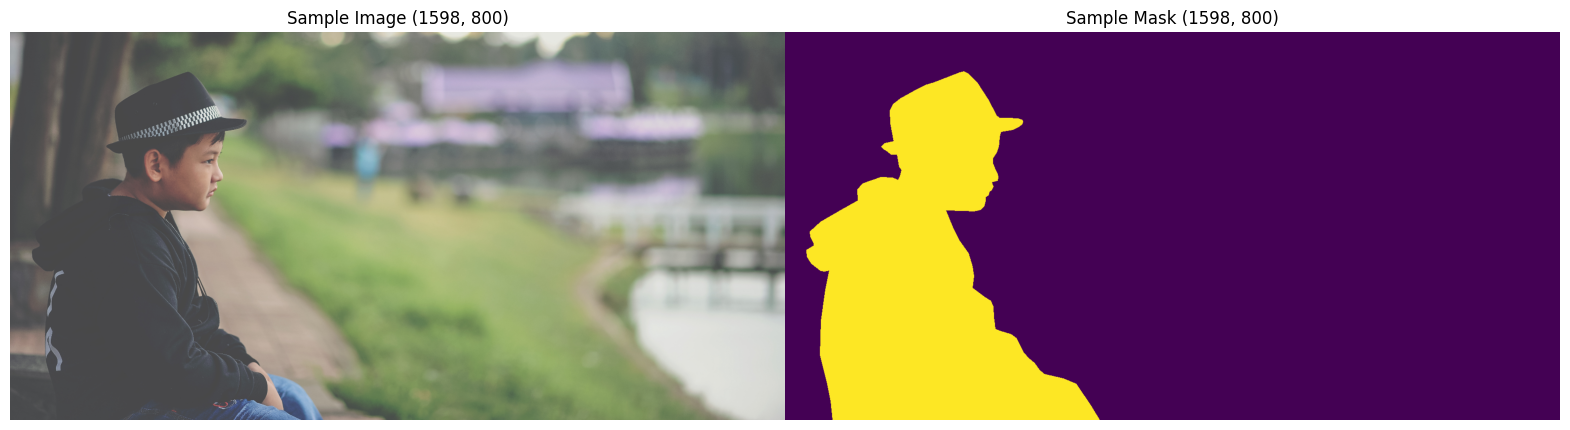

In [6]:
# visulaize the sample
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(sample_image)
axes[0].set_title(f'Sample Image {sample_image.size}')
axes[0].axis('off')
axes[1].imshow(sample_mask)
axes[1].set_title(f'Sample Mask {sample_mask.size}')
axes[1].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

initialize the dataset and dataloader objects

In [7]:
# create datasets

dataset = PersonSegmentationDataset()
validation_size = int(len(dataset) * SPLIT_SIZE)   # 20% for validation
train_size = len(dataset) - validation_size        # 80% for training
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

# create dataloaders

processor = DepthProImageProcessorFast()
def collate_fn(samples):
    images = [i[0] for i in samples]
    masks  = [i[1] for i in samples]

    images = processor(
        images,
        resample=Image.BICUBIC,
        return_tensors="pt"
    )['pixel_values']
    masks  = processor(
        masks,
        resample=Image.NEAREST,
        do_normalize=False,
        return_tensors="pt"
    )['pixel_values']

    masks  = masks[:, 0, :, :]
    return images, masks

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
)
validation_loader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
)

# DepthProForDepthEstimation and Feature Maps

Now we will use the pre-trained DepthPro model for monocular depth estimation, from huggingface and extract the feature maps to visualize them. We will later use these feature maps to generate from depth estimation for segmentation task.

Download the pre-trained depth pro model from huggingface hub

In [8]:
model = DepthProForDepthEstimation.from_pretrained(
    "geetu040/DepthPro",
    revision="project",
    use_fov_model=False,
)
model = model.to(DEVICE)

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.81G [00:00<?, ?B/s]

prepare inputs for visualizing feature maps

In [9]:
processed_sample_image, processed_sample_mask = collate_fn([[sample_image, sample_mask]])
processed_sample_image = processed_sample_image.to(model.device)
processed_sample_mask  = processed_sample_mask.to(model.device)
processed_sample_image.shape, processed_sample_mask.shape

(torch.Size([1, 3, 1536, 1536]), torch.Size([1, 1536, 1536]))

run each block of the model and store the feature maps

In [10]:
with torch.no_grad():
    encoder_features = model.depth_pro(processed_sample_image).features
    fusion_features  = model.fusion_stage(encoder_features)
    predicted_depth  = model.head(fusion_features[-1])
    predicted_depth = F.interpolate(predicted_depth.unsqueeze(1), size=(sample_mask.height, sample_mask.width)).squeeze(1)

visualize the estimated depth

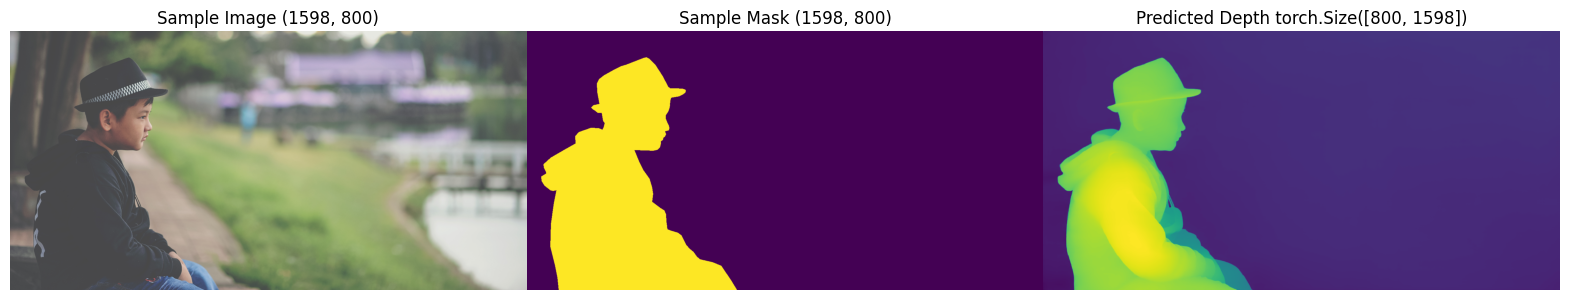

In [11]:
# visulaize the sample
fig, axes = plt.subplots(1, 3, figsize=(20, 20))
axes[0].imshow(sample_image)
axes[0].set_title(f'Sample Image {sample_image.size}')
axes[0].axis('off')
axes[1].imshow(sample_mask)
axes[1].set_title(f'Sample Mask {sample_mask.size}')
axes[1].axis('off')
axes[2].imshow(predicted_depth[0].cpu())
axes[2].set_title(f'Predicted Depth {predicted_depth[0].shape}')
axes[2].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

visualize the hidden feature maps

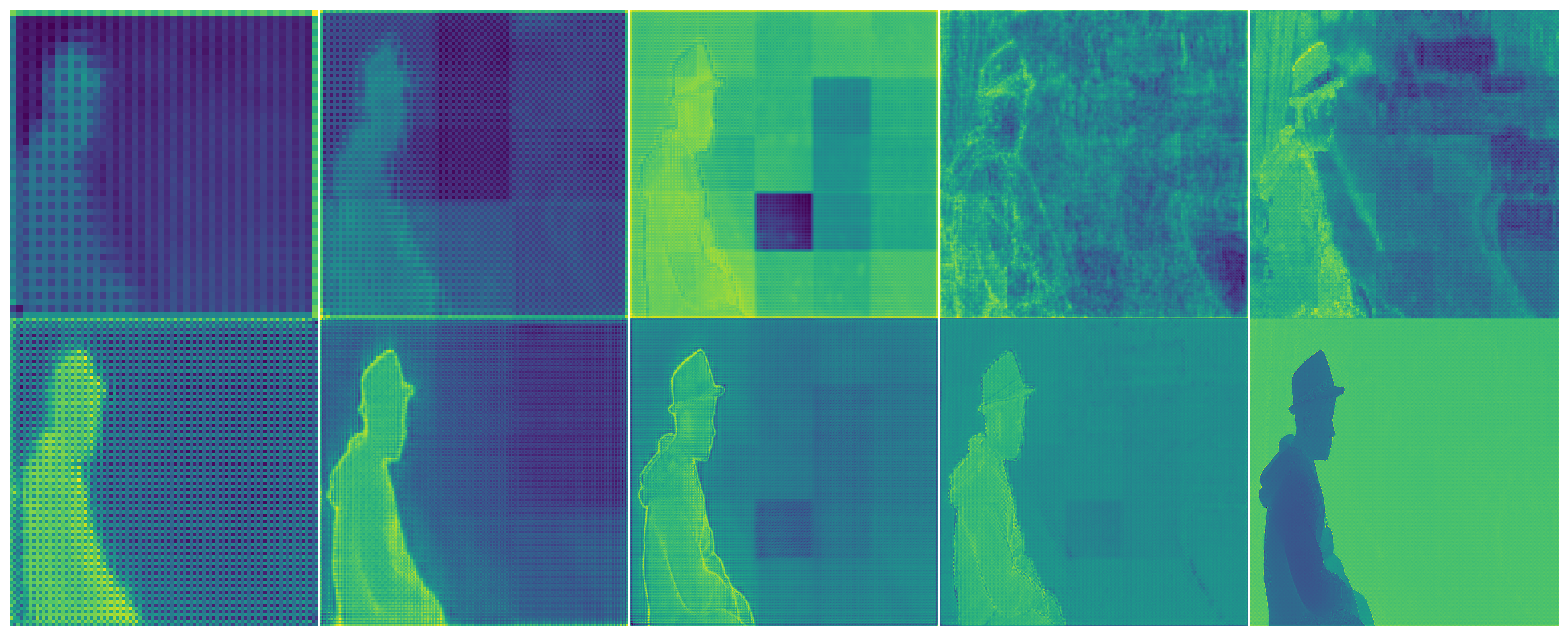

In [12]:
fig, axes = plt.subplots(2, len(encoder_features), figsize=(20, 8))
for i, outs in enumerate(zip(encoder_features, fusion_features)):
    for j, out in enumerate(outs):
        out = out.cpu().squeeze(0).mean(0)
        axes[j, i].matshow(out)
        axes[j, i].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

These feature maps from depth estimation model are rich with the semantic information of the image and can be used for segmentation tasks.

Now we will freeze the DinoV2 based encoders in DepthPro model, because of resource constraint and to speed up the training process.

Also update the head layers only for segmentation task.

In [13]:
# freeze base-vit parameters, due to computation constraints
for param in model.depth_pro.encoder.patch_encoder.parameters():
    param.requires_grad = False
for param in model.depth_pro.encoder.image_encoder.parameters():
    param.requires_grad = False

# update the head layer for image segmentaiton task
features = model.config.fusion_hidden_size
semantic_classifier_dropout = 0.1
num_labels = 1
model.head.head = nn.Sequential(
    nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(features),
    nn.ReLU(),
    nn.Dropout(semantic_classifier_dropout),
    nn.Conv2d(features, features, kernel_size=1),
    nn.ConvTranspose2d(features, num_labels, kernel_size=2, stride=2, padding=0, bias=True),
)
model = model.to(model.device) # lod the head to cuda as well

In [14]:
# test the new output shape
with torch.no_grad():
    processed_sample_image = processed_sample_image.to(model.device)
    output = model(processed_sample_image)
    output = output[0] # get output logits
print("shape: batch_size, num_channels, height, width")
print("processed_sample_image.shape:", processed_sample_image.shape)
print("processed_sample_mask.shape:", processed_sample_mask.shape)
print("output.shape:", output.shape)

shape: batch_size, num_channels, height, width
processed_sample_image.shape: torch.Size([1, 3, 1536, 1536])
processed_sample_mask.shape: torch.Size([1, 1536, 1536])
output.shape: torch.Size([1, 1536, 1536])


In [15]:
# unload the model back to cpu for lightning
model = model.cpu()
model = model.train()

# Training

create pytorch lightning module for training the model

In [16]:
class LightningModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.bce = nn.BCEWithLogitsLoss()

    def training_step(self, batch, batch_idx):
        image, mask = batch
        logits = self.model(image)[0]
        loss = self.bce(logits, mask)

        self.log("train_bce_loss", loss, prog_bar=True)
        self.log("train_mean_grad_norm", self.log_gradient_norms(), prog_bar=True)
        self.log("train_lr", self.optimizers().param_groups[0]['lr'], prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        image, mask = batch
        logits = self.model(image)[0]

        predicted_mask = torch.sigmoid(logits)
        predicted_mask = (predicted_mask > 0.5).float()

        loss = self.bce(logits, mask)
        iou = self.compute_iou(predicted_mask, mask)
        dice = self.compute_dice(predicted_mask, mask)

        self.log("val_bce_loss", loss, prog_bar=True)
        self.log("val_iou", iou, prog_bar=True)
        self.log("val_dice", dice, prog_bar=True)

        if batch_idx == 0:
            # visulaize the sample
            fig, axes = plt.subplots(1, 3, figsize=(20, 20))
            axes[0].imshow(torch.permute(image[0], (1, 2, 0)).cpu())
            axes[0].set_title(f'Image {image.shape}')
            axes[0].axis('off')
            axes[1].imshow(mask[0].cpu())
            axes[1].set_title(f'Mask {mask.shape}')
            axes[1].axis('off')
            axes[2].imshow(predicted_mask[0].cpu())
            axes[2].set_title(f'Predicted Mask {predicted_mask.shape}')
            axes[2].axis('off')
            plt.subplots_adjust(wspace=0, hspace=0)
            # save the visualization
            save_dir = os.path.join(self.logger.save_dir, self.logger.name, f"version_{self.logger.version}", "images")
            os.makedirs(save_dir, exist_ok=True)
            image_save_path = os.path.join(save_dir, f"{self.global_step}.png")
            plt.savefig(image_save_path)
            plt.close()

        return loss

    def compute_iou(self, pred, mask):
        intersection = torch.sum(pred * mask)
        union = torch.sum(pred) + torch.sum(mask) - intersection
        return intersection / (union + 1e-6)

    def compute_dice(self, pred, mask):
        intersection = torch.sum(pred * mask)
        return 2. * intersection / (torch.sum(pred) + torch.sum(mask) + 1e-6)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=5e-5
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
        # lr = lr * gamma ** step_size; where step_size = epoch
        return [optimizer], [scheduler]

    def log_gradient_norms(self):
        total_grad_norm = 0.0
        num_params = 0
        for param in self.parameters():
            if param.grad is not None:
                total_grad_norm += param.grad.norm(2).item()
                num_params += 1
        if num_params == 0:
            return 0
        return total_grad_norm / num_params

initialize and run the trainer

In [17]:
# Save the top 3 models based on PSNR score
checkpoint_callback = ModelCheckpoint(
    monitor='val_bce_loss',
    mode='min',
    save_top_k=2,
    filename='model-{epoch:02d}-{val_bce_loss:.2f}',
    save_weights_only=True,
)

# Stop training if PSNR does not improve for 3 epochs
early_stopping_callback = EarlyStopping(
    monitor='val_bce_loss',
    mode='min',
    patience=2,
    verbose=True,
    min_delta=0.005,
)

# Create Lightening Trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=1,
    val_check_interval=0.4,
    precision=16, # 16, 32 (original)
    logger=CSVLogger("logs", name="Segmentation_Human"),
    log_every_n_steps=10,
    callbacks=[checkpoint_callback, early_stopping_callback],
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm", # norm, value
)

# Initialize the model
pl_model = LightningModel(model)

# Training the model
trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=validation_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params | Mode 
-------------------------------------------------------------
0 | model | DepthProForDepthEstimation | 647 M  | train
1 | bce   | BCEWithLogitsLoss          | 0      | train
-------------------------------------------------------------
40.5 M    Trainable params
607 M     Non-trainable params
647 M     Total params
2,591.965 Total estimated model params size (MB)
1046      Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1299516..1.4160788].


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1299516..1.4160788].
Metric val_bce_loss improved. New best score: 0.057


Validation: |          | 0/? [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1299516..1.4160788].
Metric val_bce_loss improved by 0.019 >= min_delta = 0.005. New best score: 0.038
`Trainer.fit` stopped: `max_epochs=1` reached.


visualize the training logs

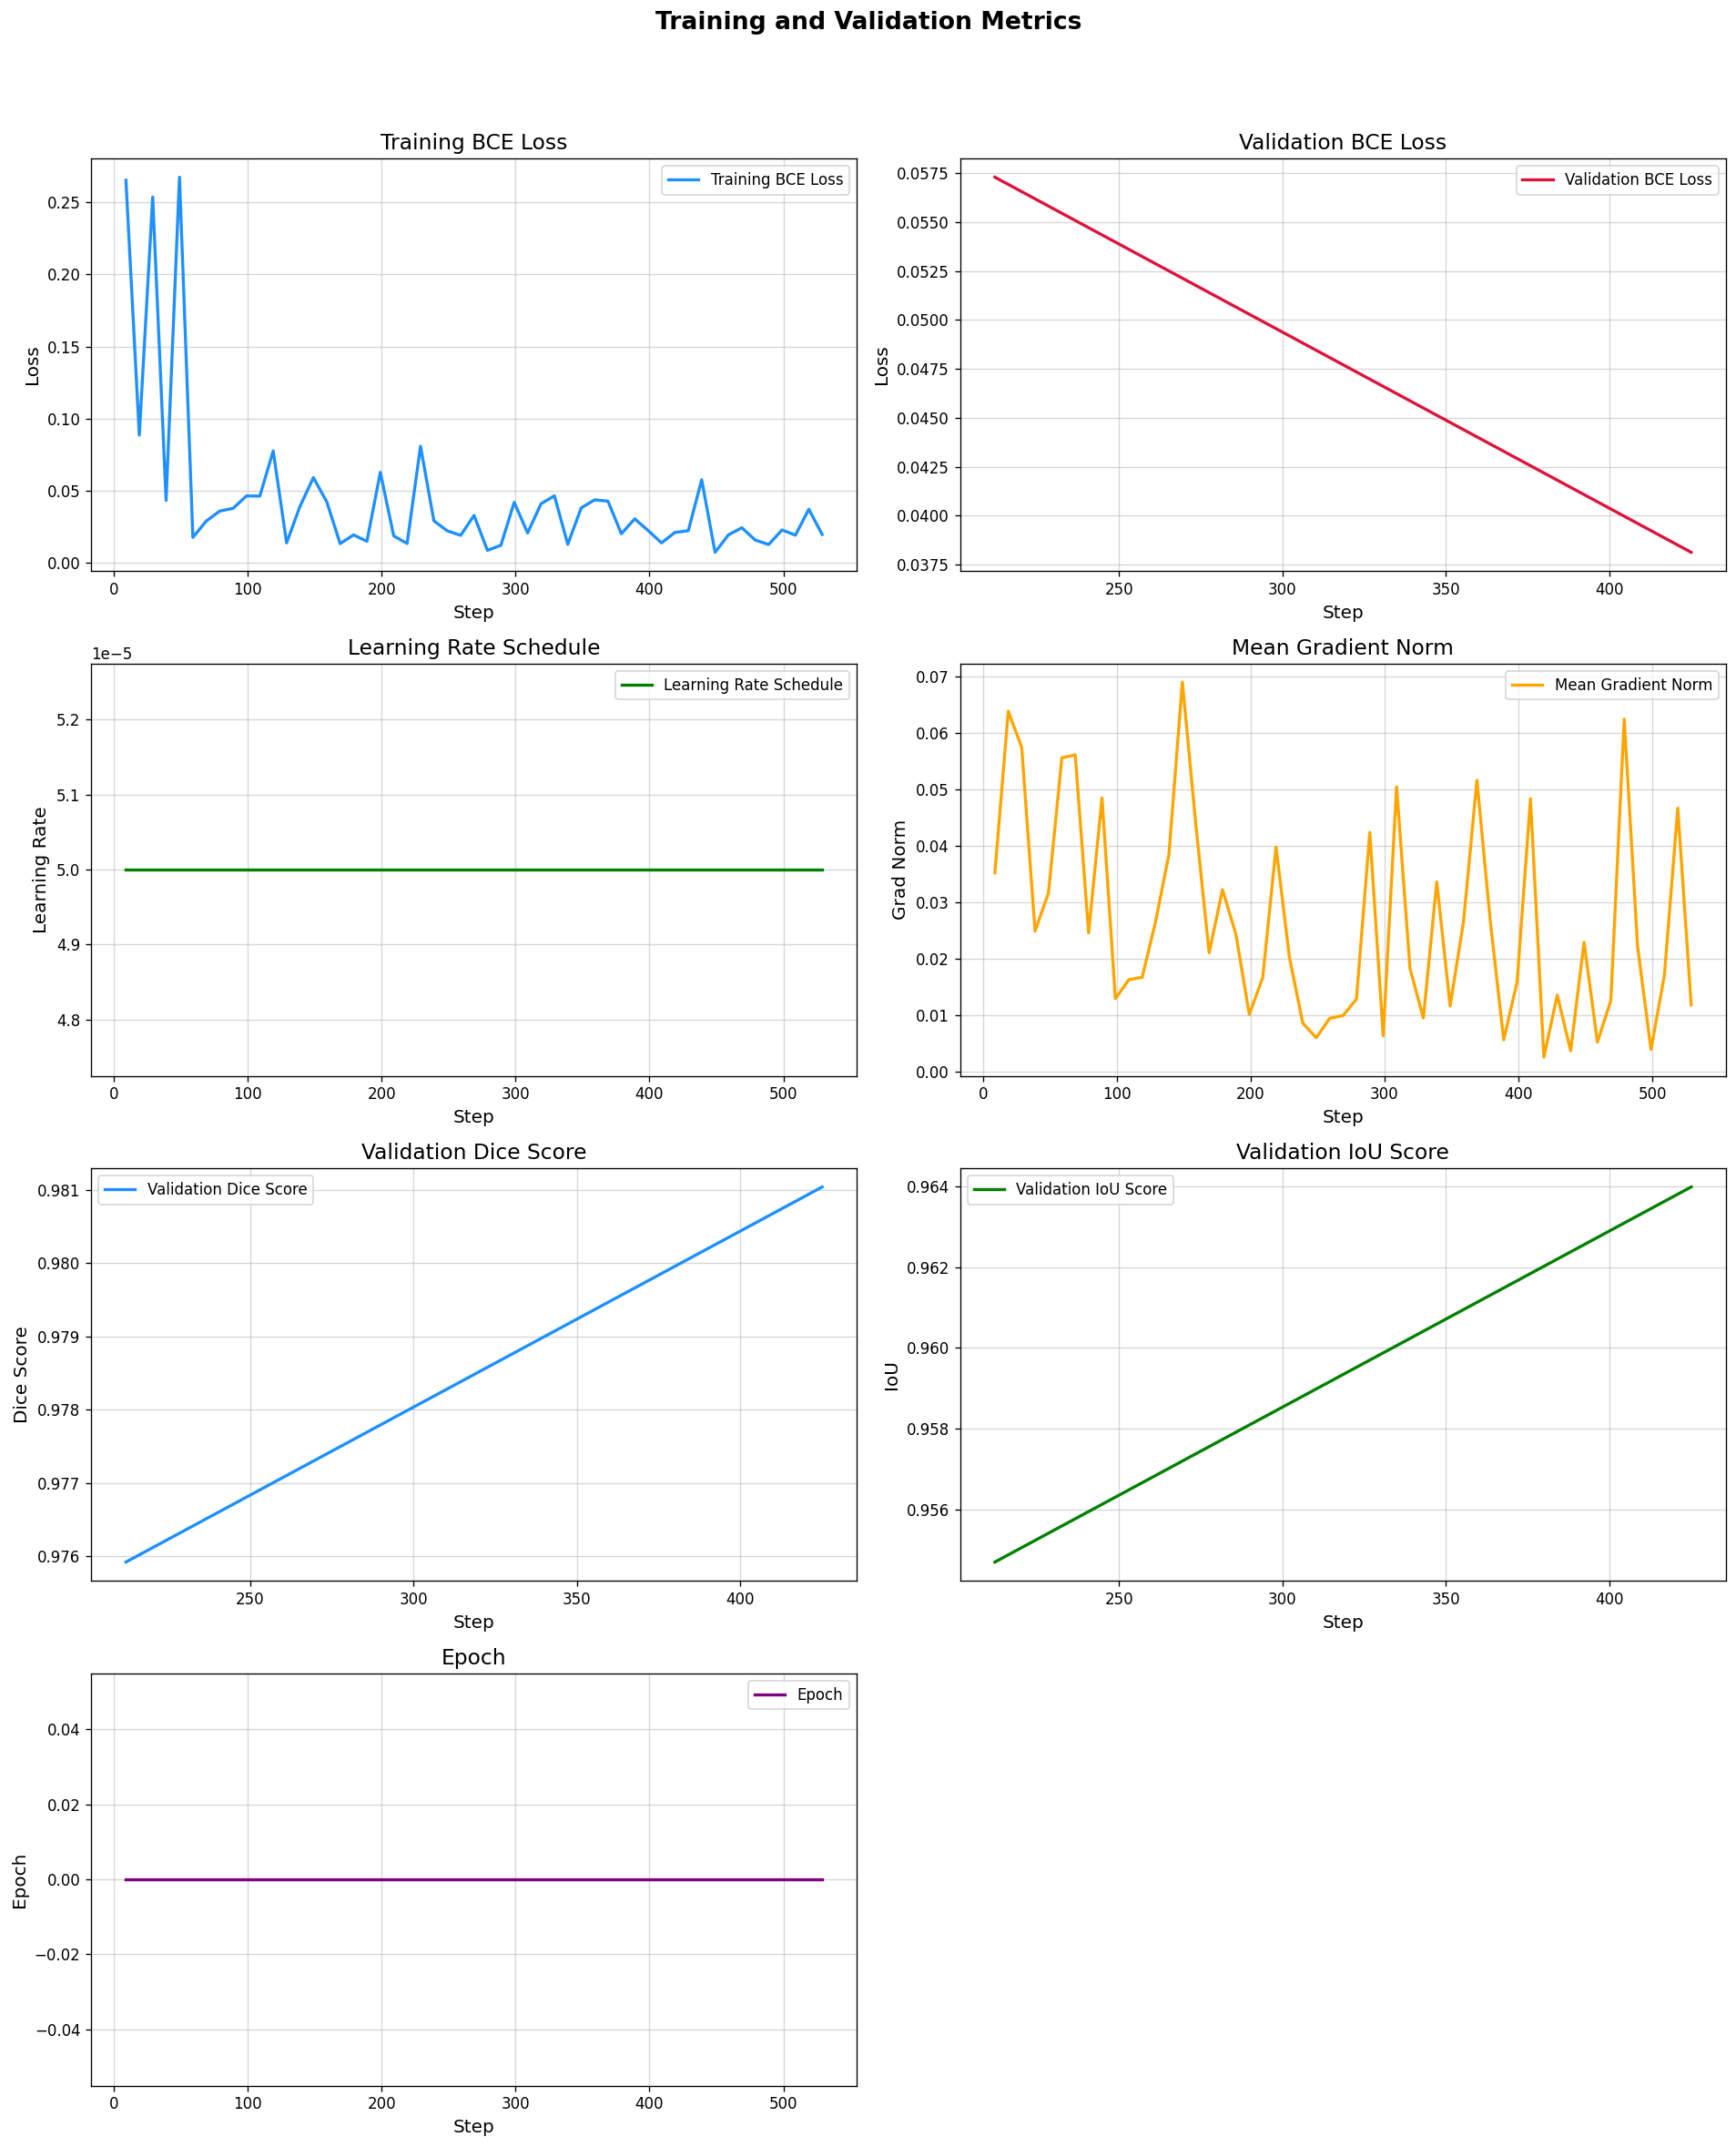

In [18]:
# Path to the CSV logs
logs_path = f"{trainer.logger.save_dir}/{trainer.logger.name}/version_{trainer.logger.version}/metrics.csv"
df = pd.read_csv(logs_path)

# Define the metrics to plot and their properties
metrics = [
    {"column": "train_bce_loss", "title": "Training BCE Loss", "ylabel": "Loss", "color": "dodgerblue"},
    {"column": "val_bce_loss", "title": "Validation BCE Loss", "ylabel": "Loss", "color": "crimson"},
    {"column": "train_lr", "title": "Learning Rate Schedule", "ylabel": "Learning Rate", "color": "green"},
    {"column": "train_mean_grad_norm", "title": "Mean Gradient Norm", "ylabel": "Grad Norm", "color": "orange"},
    {"column": "val_dice", "title": "Validation Dice Score", "ylabel": "Dice Score", "color": "dodgerblue"},
    {"column": "val_iou", "title": "Validation IoU Score", "ylabel": "IoU", "color": "green"},
    {"column": "epoch", "title": "Epoch", "ylabel": "Epoch", "color": "purple"},
]

# Determine grid size based on the number of metrics
n_metrics = len(metrics)
n_cols = 2  # Number of columns in the plot grid
n_rows = (n_metrics + n_cols - 1) // n_cols  # Calculate rows needed

# Create a figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows), dpi=120)
fig.suptitle("Training and Validation Metrics", fontsize=16, weight='bold')

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    column = metric["column"]
    title = metric["title"]
    ylabel = metric["ylabel"]
    color = metric["color"]

    # Ensure the column exists in the DataFrame
    if column in df.columns:
        valid_values = ~df[column].isna()
        axes[i].plot(df['step'][valid_values], df[column][valid_values], label=title, color=color, lw=2)
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Step", fontsize=12)
        axes[i].set_ylabel(ylabel, fontsize=12)
        axes[i].grid(alpha=0.5)
        axes[i].legend()
    else:
        # Hide the unused subplot if the metric column doesn't exist
        axes[i].axis('off')

# Hide unused subplots if the number of metrics is less than the grid size
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()

**The model produces exceptional results on validation set with an `IoU score of 0.964` and `Dice score of 0.982`, beating the [previous state of art IoU score of 0.95](https://www.kaggle.com/code/saeedghamshadzai/person-segmentation-deeplabv3-pytorch)**

# Validation and Inference

Model has achieve best `IoU score of 0.964` and `Dice score of 0.982` on validation set, we are going to use this checkpoint for inference

In [20]:
model_name = "model-epoch=00-val_bce_loss=0.04.ckpt"

checkpoint_path = f"logs/Segmentation_Human/version_0/checkpoints/{model_name}"
pl_model = LightningModel.load_from_checkpoint(
    checkpoint_path,
    model=model,
    map_location=torch.device('cpu')
)
model = pl_model.model
model = model.to(DEVICE)

In [73]:
num_samples = 20

# Randomly sample indexes from the validation dataset
indexes = random.sample(range(0, len(validation_dataset)), num_samples)

images, masks, predictions = [], [], []

# Process and predict segmentation masks
for index in tqdm(indexes):
    image, true_mask = validation_dataset[index]  # Assuming dataset returns (image, mask)

    input = processor(image, return_tensors="pt")  # Preprocess input image
    input = input['pixel_values']                 # Extract tensor
    input = input.to(DEVICE)                      # Load to CUDA

    with torch.no_grad():
        predicted_mask = model(input)[0]          # Inference step
    predicted_mask = predicted_mask.cpu()         # Unload from CUDA

    # Post-process predicted mask
    predicted_mask = F.interpolate(
        predicted_mask.unsqueeze(1),
        size=(true_mask.height, true_mask.width),
        mode='bilinear',
        align_corners=False
    ).squeeze(1)
    predicted_mask = predicted_mask.sigmoid()  # Apply sigmoid for binary segmentation (or softmax for multiclass)
    predicted_mask = (predicted_mask > 0.5).float()  # Threshold to create binary mask
    predicted_mask = predicted_mask.numpy()       # Convert to numpy array

    # Store results for visualization
    images.append(image)
    masks.append(true_mask)
    predictions.append(predicted_mask)


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


In [ ]:
# for better visualization keep images of same aspect ratio together
zipped = sorted(zip(images, masks, predictions), key=lambda x: x[0].width/x[0].height, reverse=True)

n_rows_plotted = 0
for _, (image, mask, prediction) in enumerate(zipped):
    fig, axes = plt.subplots(1, 3, figsize=(20, 20*3))
    # Plotting the images
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title("Image")
    axes[1].imshow(mask)
    axes[1].axis('off')
    axes[1].set_title("Mask")
    axes[2].imshow(prediction[0]) # binary: ignore channels
    axes[2].axis('off')
    axes[2].set_title("Prediction")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

<a href="assets/validation_outputs/Segmentation_Human.jpg">
    <img src="assets/validation_outputs/Segmentation_Human.jpg" alt="assets/validation_outputs/Segmentation_Human" width="100%">
</a>